In [44]:
import numpy as np
import proplot as pplt
import sxdes
import fitsio
import os
import subprocess
import copy

from ngmix.medsreaders import NGMixMEDS

In [73]:
img = fitsio.read("data/DES0000-4748_r5932p01_r_pizza-cutter-slices-coadd-img.fits.fz")

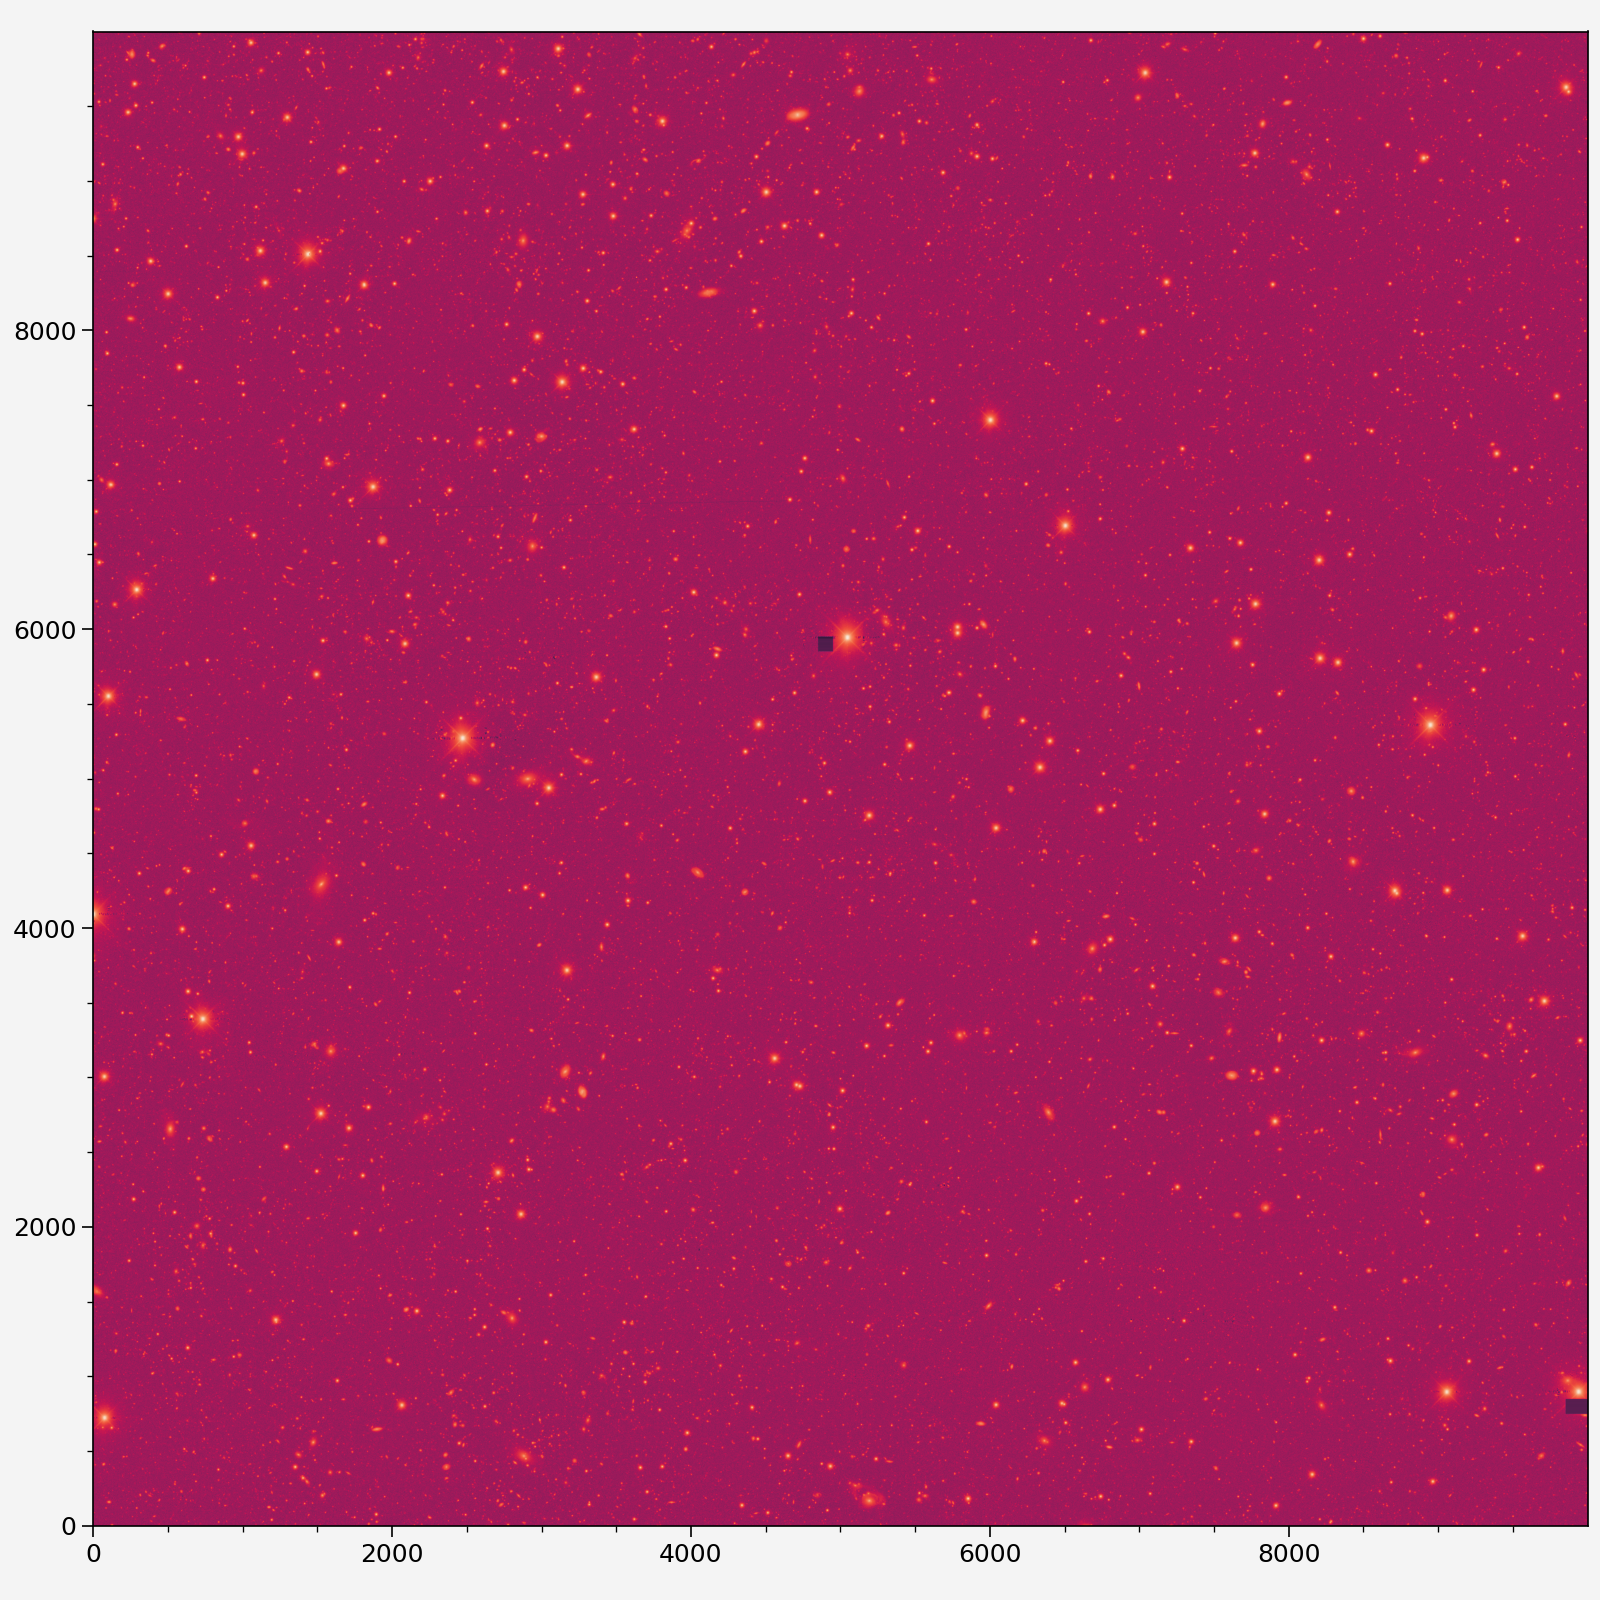

In [91]:
fig, axs = pplt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axs.imshow(np.arcsinh(img), origin="lower", cmap="rocket")
axs.grid(False)

array([[-0.2697295 , -0.33576274, -0.45862824, -0.1959647 , -2.1151748 ,
        -2.8501952 , -2.1437328 ,  2.1462765 , -2.446126  , -2.5693367 ],
       [-0.29936057,  1.1109418 , -0.27025622,  0.88023585,  1.2713487 ,
         1.4640021 ,  1.8053361 , -0.9965294 ,  1.1803792 ,  0.48576534],
       [ 0.24022734,  1.561735  , -2.6845586 ,  0.01700461, -3.2459517 ,
        -0.9886503 , -0.6905836 , -0.5186714 ,  3.3982623 ,  0.39696103],
       [-0.45469546, -3.0376358 , -4.909518  , -0.02748829, -2.6788957 ,
        -1.0322691 , -1.2282732 ,  0.1599459 ,  0.48856956, -0.9696603 ],
       [ 0.01421583, -1.9676785 , -0.913959  ,  2.0247793 , -2.0127232 ,
         0.08600008,  2.3441567 , -0.30733848, -1.0753901 ,  1.1150836 ],
       [ 0.10055894, -0.48389423,  0.50239867, -0.44719243, -1.2209842 ,
        -0.76810026, -1.3770998 , -1.9008722 , -0.22645336,  3.0958192 ],
       [ 0.51480275, -3.141329  , -0.62021756, -3.9628315 , -1.2092277 ,
         3.7550135 , -4.3371606 , -1.8391554 

In [32]:
def _download_tile(tilename, cwd="."):
    os.system("mkdir -p data")

    d = fitsio.read(
        os.path.join(cwd, "fnames.fits"),
        lower=True,
    )
    tnames = np.array([
        d["filename"][i].split("_")[0]
        for i in range(d.shape[0])
    ])
    msk = tnames == tilename
    if np.sum(msk) != 1:
        return np.sum(msk)

    d = d[msk]
    mfiles = []
    for band in ["r"]:
        msk = d["band"] == band
        if np.any(msk):
            _d = d[msk]
            for i in range(len(_d)):
                fname = os.path.join(d["path"][msk][i], d["filename"][msk][i])
                if not os.path.exists("./data/%s" % os.path.basename(fname)):
                    cmd = """\
rsync \
-av \
--password-file $DES_RSYNC_PASSFILE \
${DESREMOTE_RSYNC_USER}@${DESREMOTE_RSYNC}/%s \
./data/%s
""" % (fname, os.path.basename(fname))
                    subprocess.run(cmd, shell=True, check=True)
            mfiles.append("./data/%s" % os.path.basename(fname))

    return mfiles


In [33]:
tname = "DES0000-4748"

mfiles = _download_tile(tname)


    DES rsync daemon

receiving file list ... done
DES0000-4748_r5932p01_r_pizza-cutter-slices.fits.fz

sent 38 bytes  received 1167837213 bytes  6130379.27 bytes/sec
total size is 1167552000  speedup is 1.00


In [34]:
m = NGMixMEDS(mfiles[0])

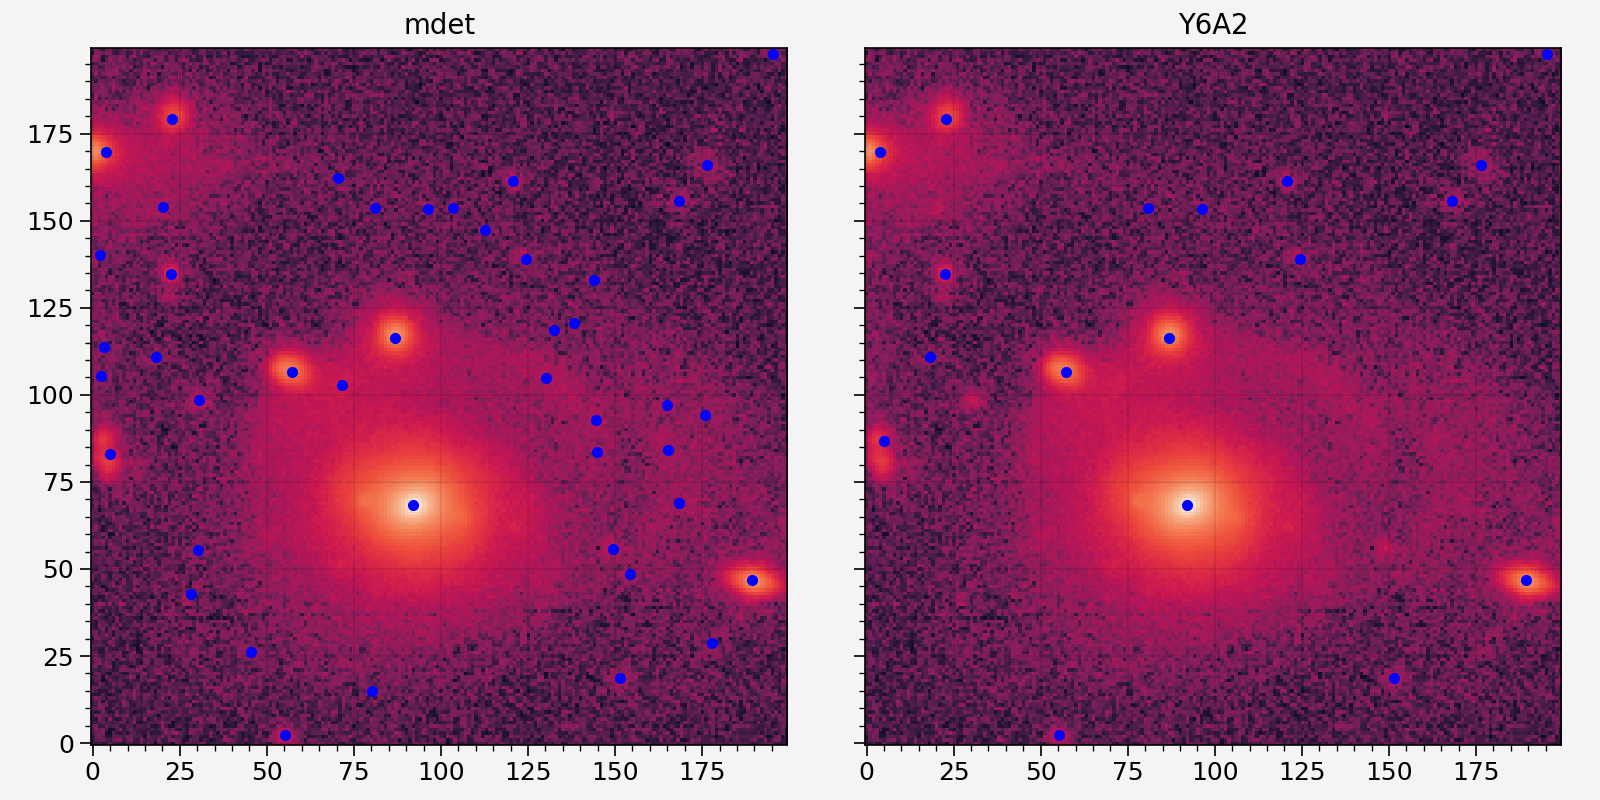

In [94]:
idd = np.argmin((m["orig_col"][:, 0] - 5200.0)**2 + (m["orig_row"][:, 0] - 200.0)**2)
# idd = np.argmin((m["orig_col"][:, 0] - 5000.0)**2 + (m["orig_row"][:, 0] - 6000.0)**2)
# idd = 4271

obs = m.get_obs(idd, 0)

base_cfg = {

    'deblend_cont': 0.00001,

    'deblend_nthresh': 64,

    'minarea': 4,

    'filter_type': 'conv',

    # 7x7 convolution mask of a gaussian PSF with FWHM = 3.0 pixels.
    'filter_kernel':  np.array([
        [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],
        [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],
        [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],
        [0.068707, 0.296069, 0.710525, 0.951108, 0.710525, 0.296069, 0.068707],
        [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328],
        [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388],
        [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963],
    ]),
}

cfg = copy.deepcopy(base_cfg)
cfg["deblend_cont"] = 0.00001
cat, _ = sxdes.run_sep(
    obs.image.copy(), 
    1.0/np.sqrt(obs.weight).copy(), 
    config=cfg,
)

cfg = copy.deepcopy(base_cfg)
cfg["deblend_cont"] = 0.001
cat_des, _ = sxdes.run_sep(
    obs.image.copy(), 
    1.0/np.sqrt(obs.weight).copy(), 
    config=cfg,
)

fig, axs = pplt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axs[0].imshow(
    np.arcsinh(obs.image*np.sqrt(obs.weight)), 
    origin="lower",
    cmap="rocket",
)
axs[0].plot(cat["x"], cat["y"], ".b")
axs[0].format(title="mdet")

axs[1].imshow(
    np.arcsinh(obs.image*np.sqrt(obs.weight)), 
    origin="lower",
    cmap="rocket",
)
axs[1].plot(cat_des["x"], cat_des["y"], ".b")
axs[1].format(title="Y6A2")

In [88]:
r2 = (m["orig_col"][:, 0] - 1500.0)**2 + (m["orig_row"][:, 0] - 4400.0)**2

In [89]:
m["id"][np.argmin(r2)]

4271

In [87]:
m["orig_col"]

array([[   99.5, -9999. ],
       [  199.5, -9999. ],
       [  299.5, -9999. ],
       ...,
       [ 9699.5, -9999. ],
       [ 9799.5, -9999. ],
       [ 9899.5, -9999. ]])